In [1]:
import os, sys, json
from scipy import stats
import numpy as np
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

### Create models from search spaces

In [2]:
with open('random_arcs_mobilenetv2.pickle', 'rb') as infile:
    obj = pickle.load(infile)

In [3]:
# architecture config

arc = obj[0]

arc

[[1, 16, 4, 1],
 [6, 32, 1, 2],
 [6, 64, 4, 2],
 [6, 128, 4, 2],
 [6, 184, 2, 1],
 [6, 320, 1, 2],
 [6, 440, 2, 1],
 [0, 536, 2, 0]]

In [4]:
from mobilenetv2 import MobileNetV2

model_s = MobileNetV2(num_classes = 100, first_stride = 1,\
                        inverted_residual_setting = arc[:-1], last_channel = arc[-1][1])

In [5]:
with open('random_arcs_shufflenetv2.pickle', 'rb') as infile:
    obj = pickle.load(infile)

In [6]:
# architecture config

arc = obj[0]

arc

{'out_channels': [98, 158, 510, 524], 'num_blocks': [6, 3, 5]}

In [7]:
from ShuffleNetv2 import ShuffleV2

model_s = ShuffleV2(num_classes=100, config = arc)

### Load benchmark

In [8]:
benchmark = pickle.load(open('benchmark.pickle', 'rb'))

In [9]:
# datasets

benchmark.keys()

dict_keys(['cifar100', 'imagenet'])

In [10]:
# search spaces

benchmark['cifar100'].keys()

dict_keys(['mobilenet', 'shufflenet'])

In [11]:
# KD methods

benchmark['cifar100']['mobilenet'].keys()

dict_keys(['attention', 'nokd', 'correlation', 'crd', 'hint', 'kd', 'nst', 'pkt', 'similarity', 'vid'])

In [12]:
# parts of train dataset

benchmark['cifar100']['mobilenet']['nst'].keys()

dict_keys([27, 9, 3])

In [13]:
# metrics for each architecture from the search space

benchmark['cifar100']['mobilenet']['nst'][9]

{0: {'test_acc': 0.41689998626708985,
  'valid_acc': 0.4229999923706055,
  'wall_time': 286.5539231300354},
 1: {'test_acc': 0.4271999740600586,
  'valid_acc': 0.4212999725341797,
  'wall_time': 264.8843615055084},
 2: {'test_acc': 0.43200000762939456,
  'valid_acc': 0.4318000030517578,
  'wall_time': 357.8804075717926},
 3: {'test_acc': 0.4515999984741211,
  'valid_acc': 0.45219997406005863,
  'wall_time': 298.00210762023926},
 4: {'test_acc': 0.4225,
  'valid_acc': 0.4239999771118164,
  'wall_time': 318.9312756061554},
 5: {'test_acc': 0.4555999755859375,
  'valid_acc': 0.45099998474121095,
  'wall_time': 435.14361596107483},
 6: {'test_acc': 0.455099983215332,
  'valid_acc': 0.4520999908447266,
  'wall_time': 305.1986322402954},
 7: {'test_acc': 0.42779998779296874,
  'valid_acc': 0.42619998931884767,
  'wall_time': 297.0506205558777},
 8: {'test_acc': 0.4562999725341797,
  'valid_acc': 0.4544999694824219,
  'wall_time': 398.249636888504},
 9: {'test_acc': 0.3755999755859375,
  'val

### Read high-fidelity

In [14]:
base_data = benchmark['cifar100']['mobilenet']['nokd'][1]

### Test accuracy histogram

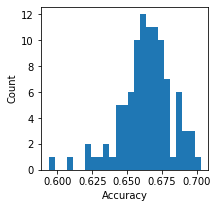

In [15]:
fig, ax = plt.subplots()

plt.hist([x['test_acc'] for x in base_data.values()], bins = 25)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Count')
fig.set_size_inches(3, 3)
plt.show()

### accuracy increase from KD

In [16]:
nokd_data = benchmark['cifar100']['mobilenet']['nokd'][27]
kd_data = benchmark['cifar100']['mobilenet']['kd'][27]

In [17]:
np.mean([nokd_data[x]['test_acc'] for x in nokd_data.keys()])

0.13390700000000003

In [18]:
np.mean([kd_data[x]['test_acc'] for x in kd_data.keys()])

0.22890200000000005

### check correlations

In [19]:
def calc_corr(label, data, top = False, verbose = True):
    
    full = []
    acc = []
    
    for k in data.keys():
        acc.append(data[k]['valid_acc'])
        full.append(base_data[k]['test_acc'])
    
    if top:
        joined = list(zip(acc, full))
        joined.sort(key = lambda x : -x[1])
      
        acc = [x[0] for x in joined[0:20]]    
        full = [x[1] for x in joined[0:20]]
    
    if verbose:
        print('%10s  Pearson: %.2f Kendall: %.2f' % (label, stats.pearsonr(full, acc)[0], stats.kendalltau(full, acc)[0]))
    
    return stats.pearsonr(full, acc)[0], stats.kendalltau(full, acc)[0]

In [20]:
def print_report(label1, label2, data, nokd_data):
        calc_corr(label1, nokd_data, top = False)
        calc_corr(label2, data, top = False)

In [21]:
nokd_data = benchmark['cifar100']['mobilenet']['nokd'][27]
kd_data = benchmark['cifar100']['mobilenet']['kd'][27]

In [22]:
print_report('no KD 3%', '   KD 3%', kd_data, nokd_data)

  no KD 3%  Pearson: 0.11 Kendall: 0.09
     KD 3%  Pearson: 0.34 Kendall: 0.23


### NAS with low-fidelity evaluations only

In [23]:
from sklearn import preprocessing

In [24]:
def get_X(ss):
    
    if ss == 'mobilenet':
        arcs_cnt = 100
    elif ss == 'shufflenet':
        arcs_cnt = 300

    #
    #
    #
    if ss == 'mobilenet':
        with open('random_arcs_mobilenetv2.pickle', 'rb') as infile:
            obj = pickle.load(infile)
            
    elif ss == 'shufflenet':
        with open('random_arcs_shufflenetv2.pickle', 'rb') as infile:
            obj = pickle.load(infile)
    
    #
    #
    #
    if ss == 'mobilenet':
        X = np.zeros((100, 16))

        for i in range(100):
            X[i] = np.array(obj[i])[:, [1,2]].flatten()
    elif ss == 'shufflenet':
        X = np.zeros((arcs_cnt, 7))

        for i in range(arcs_cnt):
            X[i] = np.array(obj[i]['out_channels'] + obj[i]['num_blocks'])
            
    X_scaled = preprocessing.scale(X, axis = 0)
    
    return X_scaled

In [25]:
X_scaled = get_X('mobilenet')

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import ttest_ind

In [27]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [28]:
def run_search_alg1(data = None, n_init = 30):

    checked_points = list(np.random.choice(list(data.keys()), size = n_init, replace = False))

    X_train = []
    y_train = []
    
    for idx in checked_points:
        X_train.append(X_scaled[idx])
        y = data[idx]['valid_acc']

        y_train.append(y)

    Y = np.zeros((n_init, 1))
    Y[:,0] = y_train

    gpr = GPR(kernel = RBF(1.0))
    gpr.fit(X_train, y_train)

    preds = gpr.predict(X_scaled, return_std = True)
    best_idx = np.argmax(preds[0])

    return best_idx

In [29]:
test_acc_list = [base_data[x]['test_acc'] for x in range(len(base_data))]
test_acc_list.sort(reverse = True)

In [30]:
def get_percentile(val, test_acc_list):
    
    idx = 0 
    
    while idx < len(test_acc_list):
        if val > test_acc_list[idx]:
            break
        idx += 1
        
    return idx / len(test_acc_list) * 100

In [31]:
percentiles = {}

for i in range(len(base_data)):
    val = base_data[i]['test_acc']
    percentiles[i] = get_percentile(val, test_acc_list)

In [32]:
def run_comparison(data_nokd, data_kd):
    
    random.seed(2)
    np.random.seed(2)
    
    n_trials = 1000
    res_kd = []
    res_nokd = []

    for i in range(n_trials):
        res_nokd.append(run_search_alg1(data_nokd))
        res_kd.append(run_search_alg1(data_kd))
    
    A_nokd = [base_data[x]['test_acc'] for x in res_nokd] 
    A_kd = [base_data[x]['test_acc'] for x in res_kd] 
    
    print(np.mean(A_nokd), np.std(A_nokd))
    print(np.mean(A_kd), np.std(A_kd))
    print(ttest_ind(A_kd, A_nokd))
    print()
    
    B_nokd = [percentiles[x] for x in res_nokd] 
    B_kd = [percentiles[x] for x in res_kd] 
    
    print(np.mean(B_nokd), np.std(B_nokd))
    print(np.mean(B_kd), np.std(B_kd))
    print(ttest_ind(B_kd, B_nokd))
    print()

In [33]:
nokd_data = benchmark['cifar100']['mobilenet']['nokd'][27]
kd_data = benchmark['cifar100']['mobilenet']['kd'][27]

In [34]:
run_comparison(nokd_data, kd_data)

0.6734325000000001 0.010392487370692345
0.6771741000000002 0.008881816210100268
Ttest_indResult(statistic=8.650606211408336, pvalue=1.0335909163268219e-17)

30.915 17.107535620304873
25.397 13.25637171325548
Ttest_indResult(statistic=-8.058540329206473, pvalue=1.3149099770458328e-15)



## Multi-fidelity NAS

In [35]:
def run_GPR(lf_data = None, max_points = None, data = base_data,\
                    first_point = None, max_value = None):

    n_init = 1

    if not first_point:
        checked_points = list(np.random.choice(list(range(len(data))), size = n_init, replace = False))
    else:
        checked_points = [first_point]
        
    while len(checked_points) < max_points:
            
        max_y = max([data[idx]['valid_acc'] for idx in checked_points])
        
        X_train = []
        y_train = []
        
        for idx in checked_points:
            X_train.append(X_scaled[idx])
            y = data[idx]['valid_acc']
    
            y_train.append(y)

        gpr = GPR(kernel = RBF(1.0), n_restarts_optimizer = 3, normalize_y = True)
        gpr.fit(X_train, y_train)
        
        preds = gpr.predict(X_scaled, return_std = True)

        max_score = 0
        best_new_idx = 0

        for idx in range(len(data)):
            if idx not in checked_points:
                score = preds[0][idx] + 0.5 * preds[1][idx]

                if score > max_score:
                    max_score = score
                    best_new_idx = idx

        if (max_value is None) or max_y < max_value:
            checked_points.append(best_new_idx)
            
        if not (max_value is None) and max_y >= max_value:
            break
        
    return checked_points, gpr.kernel_, preds

In [36]:
class RS:
    def __init__(self, hf_data, max_hf_points):
        self.hf_data = hf_data
        self.lf_points = []
        self.hf_points = []
        self.max_hf_points = max_hf_points
        
        self.done = False
        
    def step(self):
        max_value = max([self.hf_data[idx]['valid_acc'] for idx in self.hf_data])
        
        order = np.random.choice(range(len(self.hf_data)), size = len(self.hf_data), replace = False)
        
        for i in range(1, len(order)+1):
            max_y = max([self.hf_data[x]['valid_acc'] for x in order[:i]])
            
            if max_y == max_value:
                self.hf_points = order[:i]
                break
        
        self.done = True
        self.hf_iters = len(self.hf_points)

In [37]:
class HF_GPR:
    def __init__(self, hf_data, max_hf_points):
        self.hf_data = hf_data
        self.lf_points = []
        self.hf_points = []
        self.max_hf_points = max_hf_points
        self.done = False
        
    def step(self):
        max_value = max([self.hf_data[idx]['valid_acc'] for idx in self.hf_data])

        points, kernel, preds = run_GPR(max_points = self.max_hf_points, data = self.hf_data, max_value = max_value)      
        self.hf_points = points
        self.done = True

        self.hf_iters = len(self.hf_points)

In [38]:
class MF_SearchAlg2:
    def __init__(self, lf_data, hf_data, max_lf_points, max_hf_points):
        self.lf_data = lf_data
        self.hf_data = hf_data
        
        self.lf_points = []
        self.hf_points = []
        
        self.max_lf_points = max_lf_points
        self.max_hf_points = max_hf_points
    
        self.done = False
        
    def step(self):
        if not self.lf_points:
            points, kernel, preds = run_GPR(max_points = self.max_lf_points, data = self.lf_data,
                                         first_point = None)
        
            self.lf_points = points 
            
            idx = np.argmax([self.lf_data[x]['valid_acc'] for x in self.lf_points])
            self.first_point = self.lf_points[idx]
            
        else:
            max_value = max([self.hf_data[idx]['valid_acc'] for idx in self.hf_data])
            
            points, kernel, preds = run_GPR(max_points = self.max_hf_points, data = self.hf_data,
                                             first_point = self.first_point, max_value = max_value)
            
            self.hf_points = points
            self.done = True
    
            self.hf_iters = len(self.hf_points)

In [39]:
def run_experiment(creator, n_trials, verbose = False):
    np.random.seed(2)
    random.seed(2)

    hf_iters_avg = 0
    wall_time_avg = 0
    
    time_list_avg = np.zeros(1000)
    acc_list_avg = np.zeros(1000)

    for trial in range(n_trials):
        obj = creator()
        
        while not obj.done:
            obj.step()
            
        if verbose:
            print()
            print(obj.lf_points)
            print(obj.first_point)
            print(obj.hf_points)
        
        w_time = 0.0
        time_list = []
        acc_list = []
        
        for idx in range(len(obj.lf_points)):
            point = obj.lf_points[idx]
            
            w_time += obj.lf_data[point]['wall_time']
            time_list.append(w_time)
            
            best_idx = np.argmax([obj.lf_data[x]['valid_acc'] for x in obj.lf_points[0:idx+1]])
            best_point = obj.lf_points[best_idx]
            
            acc_list.append(obj.hf_data[best_point]['valid_acc'])
            
        for idx in range(len(obj.hf_points)):
            point = obj.hf_points[idx]
            
            w_time += obj.hf_data[point]['wall_time']
            time_list.append(w_time)
            
            best_idx = np.argmax([obj.hf_data[x]['valid_acc'] for x in obj.hf_points[0:idx+1]])
            best_point = obj.hf_points[best_idx]
            
            acc_list.append(obj.hf_data[best_point]['valid_acc'])
            
        time_list = time_list + [w_time for _ in range(1000 - len(time_list))]
        acc_list = acc_list + [acc_list[-1] for _ in range(1000 - len(acc_list))]
        
        time_list_avg += np.array(time_list)
        acc_list_avg += np.array(acc_list)

        hf_iters_avg += obj.hf_iters
        wall_time_avg += sum([obj.lf_data[x]['wall_time'] for x in obj.lf_points])
        wall_time_avg += sum([obj.hf_data[x]['wall_time'] for x in obj.hf_points])

    hf_iters_avg /= n_trials
    wall_time_avg /= n_trials
    
    time_list_avg /= n_trials
    acc_list_avg /= n_trials
    
    return (hf_iters_avg, wall_time_avg, time_list_avg, acc_list_avg)

### random search

In [40]:
rs = lambda : RS(base_data, len(base_data))

In [41]:
res = run_experiment(rs, 100)

In [42]:
print(res[1])

86775.35825209857


### High-fidelity only GPR

In [43]:
hf_gpr = lambda : HF_GPR(base_data, len(base_data))

In [44]:
res = run_experiment(hf_gpr, 100)

In [45]:
print(res[1])

13437.436940178872


### Multi-fidelity NAS (Algorithm 2)

In [46]:
lf_data = benchmark['cifar100']['mobilenet']['nst'][9]

In [47]:
mf_init = lambda : MF_SearchAlg2(lf_data, base_data, 10, len(base_data))
res = run_experiment(mf_init, 100)

In [48]:
res[1]

15239.584509215354